In [2]:
# Homework 4 VRPPD

import pandas as pd      #import file from csv.file
import numpy as np       #library to improve the calculate
from docplex.mp.model import Model 
mdl = Model("vrppd")
import matplotlib.pyplot as plt     #library to create graph


#---read data from csv file
df = pd.read_csv("./Data_HM4/dataset_vrppd .csv")  

In [3]:
#definition of parameter
n = 8 #orders
work_time = 480 #maximum working time[min]
P = []      #set of pickup nodes
for i in range (len(df)):
    if (df.Demand[i]>0):
        P.append(df.Node[i])   
print(P)
D = []      #set of delivery nodes 
for i in range(len(df)):
    if (df.Demand[i]<0):
        D.append(df.Node[i])
print (D)
N  = P + D  #set of pickup + delivery nodes
print(N)
V = [0] + P + D + [2*n+1]   #set of pickup + delivery + start_depot + end_depot
print (V)
K = 8   #number of assume available vehicles 
M = 9999    #Big M
v = 60 #avarge speed in [Km/h]
L = 735     #maximum duration of journey
V_without_0 = P + D + [2*n+1]   #set of pickup + delivery + end_depot
V_without_last = [0] + P + D    #set of pickup + delivery + start_depot
Q = 9       #vehicles capacity [kg]
s = []      #Service time at the node i 
for i in range (len(df)):
    s.append(df.serv_time[i])
print (s)
q = []      #demand q at node i
for i in range(len(df)):
    q.append(df.Demand[i])
print (q)
X = []  #coordinate x of the nodes 
Y = []  #coordinate y of the nodes
for i in range(len(df)):
    X.append(df.coord_x[i])
    Y.append(df.coord_y[i])
time = {(i,j): np.hypot(X[i] - X[j],Y[i]-Y[j])/v*60  for i in V for j in V if i != j}   #travel distance between each node
A = [(i,j) for i in V for j in V if i != j]     #set of arcs

[1, 2, 3, 4, 5, 6, 7, 8]
[9, 10, 11, 12, 13, 14, 15, 16]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[0, 5, 3, 6, 6, 9, 5, 10, 4, 5, 3, 6, 6, 9, 5, 10, 4, 0]
[0, 1, 2, 4, 8, 1, 2, 4, 8, -1, -2, -4, -8, -1, -2, -4, -8, 0]


In [4]:
#Decision variable 

x = mdl.binary_var_dict(((i,j,k) for (i,j) in A for k in range (K)), name='x')       #arc i,j used by vehicles k
C = mdl.continuous_var_matrix(V,K,name ='c')        #amount stored after passing in a node
T = mdl.continuous_var_matrix(V,K,name ='T')        #time before doing activity in a node

#Objective function

mdl.minimize(mdl.sum(mdl.sum(time[(i,j)]*x[(i,j,k)]for (i,j) in A) for k in range (K)))

In [5]:
#Constraint 

# Each request must be served exactly once
for i in P:
    mdl.add_constraint(mdl.sum(mdl.sum(x[(i,j,k)] for j in (V_without_0) if i!=j) for k in range (K) )==1)

#Pickup and delivery nodes of same request must be assigned to the same vehicles    
for i in P:
    for k in range (K):
            mdl.add_constraint(mdl.sum(x[(i,j,k)] for j in (V_without_0) if i!=j) - mdl.sum(x[(n+i,j,k)] for j in (V_without_0) if (n+i!=j))==0)

#Each vehicles travel at most one route starting and ending at the depot 
for k in range(K):
    mdl.add_constraint(mdl.sum(x[(0,j,k)]for j in (V_without_0))<=1)

for k in range(K):
    mdl.add_constraint(mdl.sum(x[(i,2*n+1,k)]for i in (V_without_last))<=1)

#The number of arcs enetering and exiting each node must be the same
for k in range (K):
    for i in N:
        mdl.add_constraint(mdl.sum(x[(i,j,k)] for j in (V_without_0) if i != j)- mdl.sum(x[(j,i,k)]for j in (V_without_last) if i!=j)==0)

#consistency of time    
for i in V_without_last:
    for j in V_without_0:
        for k in range (K):
            if i !=j:
                mdl.add_constraint(T[(i,k)]+s[i]+time[(i,j)] - T[(j,k)]<= (1-x[(i,j,k)])*M)     

#consistency of loads
for k in range (K):
    for i,j in A:
        if (i != 2*n and j != 0):
            mdl.add_constraint(C[(i,k)] + q[j] - C[(j,k)] <= (1 - x[(i,j,k)])*M)       

#Each pickup point must be visited before the corresponding delivery one
for i in P:
    for k in range (K):
        mdl.add_constraint(T[(n+i,k)]-T[(i,k)] - s[i]- time[(i,n+i)]>=0)       

#route duration
for k in range (K):
    mdl.add_constraint(T[(2*n+1,k)]-T[(0,k)]<=L)

#Vehicle capacity
for i in V:
    for k in range (K):
        mdl.add_constraint(C[(i,k)]<= mdl.min(Q,Q+q[i]))
        mdl.add_constraint(C[(i,k)]>=mdl.max(0,q[i]))

#positive constraint
for k in range(K):
    for i in V:
        mdl.add_constraint(T[(i,k)]>=0)

for k in range(K):
    for i in V:
        mdl.add_constraint(C[(i,k)]>=0)



In [13]:
#visualization of the optimization problem and disply of solution 

mdl.export_to_string()
sol = mdl.solve()
sol.display()

solution for: vrppd
objective: 1033.802
status: OPTIMAL_SOLUTION(2)
x_0_6_2 = 1
x_0_7_7 = 1
x_1_5_7 = 1
x_2_10_7 = 1
x_3_11_2 = 1
x_4_12_2 = 1
x_5_15_7 = 1
x_6_14_2 = 1
x_7_1_7 = 1
x_8_16_7 = 1
x_9_2_7 = 1
x_10_8_7 = 1
x_11_4_2 = 1
x_12_17_2 = 1
x_13_17_7 = 1
x_14_3_2 = 1
x_15_9_7 = 1
x_16_13_7 = 1
c_1_0 = 1.000
c_1_1 = 1.000
c_1_2 = 1.000
c_1_3 = 1.000
c_1_4 = 1.000
c_1_5 = 9.000
c_1_6 = 9.000
c_1_7 = 5.000
c_2_0 = 2.000
c_2_1 = 2.000
c_2_2 = 2.000
c_2_3 = 2.000
c_2_4 = 2.000
c_2_5 = 2.000
c_2_6 = 2.000
c_2_7 = 3.000
c_3_0 = 4.000
c_3_1 = 4.000
c_3_2 = 4.000
c_3_3 = 4.000
c_3_4 = 4.000
c_3_5 = 4.000
c_3_6 = 4.000
c_3_7 = 4.000
c_4_0 = 8.000
c_4_1 = 8.000
c_4_2 = 9.000
c_4_3 = 9.000
c_4_4 = 9.000
c_4_5 = 9.000
c_4_6 = 9.000
c_4_7 = 8.000
c_5_0 = 1.000
c_5_1 = 1.000
c_5_2 = 1.000
c_5_3 = 1.000
c_5_4 = 1.000
c_5_5 = 1.000
c_5_6 = 1.000
c_5_7 = 6.000
c_6_0 = 2.000
c_6_1 = 2.000
c_6_2 = 2.000
c_6_3 = 2.000
c_6_4 = 2.000
c_6_5 = 2.000
c_6_6 = 2.000
c_6_7 = 2.000
c_7_0 = 4.000
c_7_1 = 4.000


In [31]:
#---implemnat the code to have a output easy to understand that the drive can understand 

all_street = {}

for k in range(K):
    active_A = [(i, j) for i, j in A if x[(i, j, k)].solution_value > 0]

    if active_A:
        routes = {1: [active_A[0][0], active_A[0][1]]}
        active_A.pop(0)
        i = 1

        while len(active_A) > 0:
            for a in active_A:
                if a[0] == routes[i][-1]:
                    arc = a
                    break
            routes[i].append(arc[1])
            active_A.remove(arc)
            if arc[1] == 0 and len(active_A) > 0:
                i += 1
                routes[i] = [0]

        all_street[k+1] = routes

print(all_street)

#Total travel distance 

Tot_time = sol.get_objective_value()
print("The total travel time is:",Tot_time,"[min]")

#routes duration per each vehicles 
duration =[k for k in range (K)]

for k in range (K):
    duration[k] = 0

for k in range(K):
    for (i,j) in A:
        if (x[(i, j, k)].solution_value ==1):
            duration[k] += time[i,j]

for k in range (K):
    if duration[k] == 0:
        print("The vehicle",k+1,"will not be used because not necessary")
    elif  duration [k]>0:
        print("The vehicles",k+1,"will work with a value of travel time of",duration[k],"[min]")
        
#---replacement of the worker in excess of the maximum working time 

replacement = None

for k in range(K):
    duration[k]=0
    for (i, j) in A:
        if x[(i, j, k)].solution_value == 1:
            duration[k] += time[i, j]
            if duration[k] >= 480:
                replacement = (i, j)[0]
                k_change = k
                break  # Se la somma supera 480, esci dal ciclo interno

# Ora 'last_solution' conterrà l'ultima coppia (i, j) che soddisfa la condizione
if replacement is not None:
    print("Change driver of vehicle"  ,k_change+1, "at node",replacement,)
else:
    print("No driver change")

{3: {1: [0, 6, 14, 3, 11, 4, 12, 17]}, 8: {1: [0, 7, 1, 5, 15, 9, 2, 10, 8, 16, 13, 17]}}
The total travel time is: 1033.8018464193374 [min]
The vehicle 1 will not be used because not necessary
The vehicle 2 will not be used because not necessary
The vehicles 3 will work with a value of travel time of 458.2243552428703 [min]
The vehicle 4 will not be used because not necessary
The vehicle 5 will not be used because not necessary
The vehicle 6 will not be used because not necessary
The vehicle 7 will not be used because not necessary
The vehicles 8 will work with a value of travel time of 575.577491176467 [min]
Change driver of vehicle 8 at node 13


Text(0.5, 1.0, 'graph of the route')

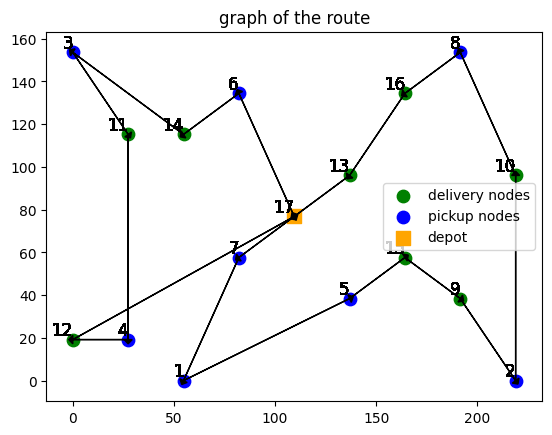

In [15]:
#---implementation of the code to have a graph output 
plt.scatter(X[n+1:-1], Y[n+1:-1], s=80, marker='o', label='delivery nodes', c='green')
plt.scatter(X[1:n+1], Y[1:n+1], s=80, marker='o', label='pickup nodes', c='blue')
plt.scatter(X[0], Y[0], s=100, marker='s', label='depot', c='orange' )  

for (i,j) in A:
    for k in range(K):
        if (sol.get_value(x[(i,j,k)])==1):
            plt.arrow(X[i],Y[i],X[j]-X[i],Y[j]-Y[i],head_width=4, head_length=2, fc='black', ec='black')
        if (i !=0):
            plt.text(X[i],Y[i],i,ha='right', va='bottom', fontsize=12, color='black')

plt.legend()
plt.title('graph of the route')